In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import warnings

In [2]:
class CorrectedExtendedHypergraphResultsAggregator:
    
    def __init__(self, results_dir="results"):
        self.results_dir = Path(results_dir)
        self.methods = ['HPRA', 'Word_Embeddings', 'HyperGNN', 'CHESHIRE']
        
        # Task mapping based on your file structure
        self.task_file_mapping = {
            'hypergraph_reconstruction': 'hypergraph_reconstruction',
            'hypergraph_prediction': 'prediction',
            'hypergraph_temporal_prediction': 'temporal_prediction'
        }
        
        self.display_tasks = ['hypergraph_reconstruction', 'prediction', 'temporal_prediction']
        
        # EXACT metric names from your debug output
        self.ml_metrics = [
            'F1 Score', 'Recall', 'Precision', 'Accuracy', 'ROC-AUC', 'Log Loss', 'Matthews Coefficient'
        ]
        
        # Alternative metric names that might be in the data
        self.metric_aliases = {
            'F1 Score': ['f1', 'f1_score', 'F1', 'F1-Score'],
            'Recall': ['recall', 'sensitivity', 'true_positive_rate'],
            'Precision': ['precision', 'positive_predictive_value'],
            'Accuracy': ['accuracy', 'acc'],
            'ROC-AUC': ['roc_auc', 'auc', 'roc-auc', 'ROC_AUC', 'area_under_curve'],
            'Log Loss': ['log_loss', 'logloss', 'cross_entropy'],
            'Matthews Coefficient': ['matthews_corrcoef', 'matthews_correlation_coefficient', 'mcc', 'matthews_coeff', 'matthews_coefficient']
        }
        
        self.example_names = []  # Will be extracted from data
        self.all_results = {}
        
    def _parse_value(self, value):
        """
        CORRECTED: Parse value that might be a number or a string like "0.7811 ± 0.0988".
        Returns the numeric value (mean if it's mean±std format).
        """
        if value is None:
            return 0.0
            
        if isinstance(value, (int, float)):
            # Handle inf and -inf
            if np.isinf(value) or np.isnan(value):
                return float('inf') if value > 0 else 0.0
            return float(value)
            
        elif isinstance(value, str):
            value = value.strip()
            
            # Handle 'inf' string
            if value.lower() in ['inf', 'infinity', '+inf']:
                return float('inf')
            if value.lower() in ['-inf', '-infinity']:
                return float('-inf')
            if value.lower() in ['nan', 'none', 'null', '']:
                return 0.0
                
            # Try to parse "mean ± std" format
            match = re.match(r'([0-9.-]+)\s*[±+/-]\s*([0-9.-]+)', value)
            if match:
                try:
                    mean_value = float(match.group(1))
                    return mean_value
                except ValueError:
                    pass
            
            # Try to parse as a simple number
            try:
                parsed = float(value)
                if np.isinf(parsed) or np.isnan(parsed):
                    return float('inf') if parsed > 0 else 0.0
                return parsed
            except ValueError:
                # Last resort: try to extract first number from string
                numbers = re.findall(r'[0-9.-]+', value)
                if numbers:
                    try:
                        return float(numbers[0])
                    except ValueError:
                        pass
                return 0.0
        else:
            return 0.0
    
    def _find_metric_value(self, result_dict, metric_name):
        """
        CORRECTED: Find metric value using multiple possible key names.
        """
        # First try exact match
        if metric_name in result_dict:
            return result_dict[metric_name]
        
        # Try aliases
        if metric_name in self.metric_aliases:
            for alias in self.metric_aliases[metric_name]:
                if alias in result_dict:
                    return result_dict[alias]
        
        # Try case-insensitive search
        metric_lower = metric_name.lower()
        for key in result_dict.keys():
            if key.lower() == metric_lower:
                return result_dict[key]
        
        # Try partial matches for Matthews coefficient specifically
        if 'matthews' in metric_name.lower():
            for key in result_dict.keys():
                if 'matthews' in key.lower() or 'mcc' in key.lower():
                    return result_dict[key]
        
        return None
        
    def load_all_results(self):        
        for method in self.methods:
            method_dir = self.results_dir / method
            if not method_dir.exists():
                print(f"⚠️  Warning: Directory {method_dir} not found")
                continue
                
            self.all_results[method] = {}
            json_files = list(method_dir.glob("*.json"))
            print(f"\n🔍 {method}: Found {len(json_files)} files")
            
            for json_file in json_files:
                # Extract task name from filename
                filename = json_file.stem
                if filename.endswith('_results'):
                    file_task_name = filename[:-8]
                else:
                    file_task_name = filename
                
                # Map to display task name
                display_task = self.task_file_mapping.get(file_task_name, file_task_name)
                
                try:
                    with open(json_file, 'r') as f:
                        data = json.load(f)
                    self.all_results[method][display_task] = data
                    print(f"  ✅ {display_task} (from {json_file.name})")
                    
                    # DEBUG: Check for Matthews coefficient in first result
                    if 'results' in data and data['results']:
                        first_result = data['results'][0]
                        matthews_value = self._find_metric_value(first_result, 'Matthews Coefficient')
#                         if matthews_value is not None:
#                             print(f"    🔍 Matthews found: {matthews_value}")
#                         else:
#                             print(f"    ⚠️  Matthews not found. Available keys: {list(first_result.keys())}")
                            
                except Exception as e:
                    print(f"  ❌ Error loading {json_file}: {e}")
        
        self._extract_example_names()
        
    def _extract_example_names(self):
        """Extract actual example names from the loaded data."""
        example_names_set = set()
        
        for method in self.all_results:
            for task in self.all_results[method]:
                if 'results' in self.all_results[method][task]:
                    results = self.all_results[method][task]['results']
                    for result in results:
                        if 'Hypergraph' in result:
                            example_names_set.add(result['Hypergraph'])
        
        if example_names_set:
            self.example_names = sorted(list(example_names_set))
            print(f"\n📋 Found examples: {self.example_names}")
            self._abbreviate_example_names()
        else:
            print("\n⚠️  No examples found in data")
    
    def _abbreviate_example_names(self):
        """Abbreviate example names for better table formatting."""
        abbreviation_map = {
            # Add abbreviations if needed
        }
        
        original_names = self.example_names.copy()
        self.example_names = [abbreviation_map.get(name, name) for name in self.example_names]
        print(f"📝 Abbreviated to: {self.example_names}")
        
        # Store mapping for reverse lookup
        self.name_mapping = {}
        for orig, abbrev in zip(original_names, self.example_names):
            self.name_mapping[abbrev] = orig
    
    def create_extended_method_comparison(self, task_name):
        """Create comparison table showing all methods for a specific task."""
        print(f"\n{'='*100}")
        print(f"📊 EXTENDED METHOD COMPARISON FOR TASK: {task_name.upper()}")
        print(f"All {len(self.ml_metrics)} ML Performance Metrics")
        print(f"{'='*100}")
        
        comparison_data = []
        
        for method in self.methods:
            if method in self.all_results and task_name in self.all_results[method]:
                results = self.all_results[method][task_name]['results']
                
                # Calculate average scores for all ML metrics
                row = {'Method': method}
                for metric in self.ml_metrics:
                    values = []
                    for r in results:
                        # CORRECTED: Use new metric finding function
                        raw_value = self._find_metric_value(r, metric)
                        if raw_value is not None:
                            parsed_value = self._parse_value(raw_value)
                            # Include all valid values, including 0
                            if not (np.isnan(parsed_value) or (parsed_value == float('inf') and metric != 'Log Loss')):
                                values.append(parsed_value)
                    
                    avg_value = np.mean(values) if values else 0
                    row[metric] = avg_value
                
                comparison_data.append(row)
        
        if comparison_data:
            df = pd.DataFrame(comparison_data)
            print(df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
            return df
        else:
            print("❌ No data available for this task")
            return None
    
    def create_example_based_comparison(self, task_name):
        """Create comparison tables for each example."""
        print(f"\n{'='*100}")
        print(f"📊 EXAMPLE-BASED COMPARISON FOR TASK: {task_name.upper()}")
        print(f"Performance of Methods on Different Examples")
        print(f"{'='*100}")
        
        example_comparisons = {}
        
        for example_abbrev in self.example_names:
            original_name = self.name_mapping.get(example_abbrev, example_abbrev)
            print(f"\n📈 {example_abbrev.upper()}:")
            print("-" * 80)
            
            comparison_data = []
            
            for method in self.methods:
                if method in self.all_results and task_name in self.all_results[method]:
                    results = self.all_results[method][task_name]['results']
                    
                    # Find results for this specific example
                    example_result = None
                    for r in results:
                        if r.get('Hypergraph') == original_name:
                            example_result = r
                            break
                    
                    if example_result:
                        row = {'Method': method}
                        for metric in self.ml_metrics:
                            # CORRECTED: Use new metric finding function
                            raw_value = self._find_metric_value(example_result, metric)
                            parsed_value = self._parse_value(raw_value) if raw_value is not None else 0.0
                            row[metric] = parsed_value
                        comparison_data.append(row)
            
            if comparison_data:
                df = pd.DataFrame(comparison_data)
                example_comparisons[example_abbrev] = df
                print(df.to_string(index=False, float_format=lambda x: f'{x:.3f}'))
            else:
                print(f"❌ No data available for {example_abbrev}")
        
        return example_comparisons
    
    def create_cross_example_analysis(self, task_name):
        """Create analysis showing how each method performs across different examples."""
        print(f"\n{'='*100}")
        print(f"📊 CROSS-EXAMPLE ANALYSIS FOR TASK: {task_name.upper()}")
        print(f"How Methods Perform Across Different Examples")
        print(f"{'='*100}")
        
        for metric in self.ml_metrics:
            print(f"\n📈 {metric.upper()} ACROSS EXAMPLES:")
            print("-" * 80)
            
            # Create matrix: methods vs examples
            matrix_data = []
            
            for method in self.methods:
                if method in self.all_results and task_name in self.all_results[method]:
                    row = {'Method': method}
                    results = self.all_results[method][task_name]['results']
                    
                    for example_abbrev in self.example_names:
                        original_name = self.name_mapping.get(example_abbrev, example_abbrev)
                        
                        # Find the value for this example
                        value = 0
                        for r in results:
                            if r.get('Hypergraph') == original_name:
                                # CORRECTED: Use new metric finding function
                                raw_value = self._find_metric_value(r, metric)
                                value = self._parse_value(raw_value) if raw_value is not None else 0.0
                                break
                        row[example_abbrev] = value
                    
                    matrix_data.append(row)
            
            if matrix_data:
                df = pd.DataFrame(matrix_data)
                
                # Split into two parts if too wide
                if len(self.example_names) > 4:
                    mid_point = len(self.example_names) // 2
                    examples_1 = self.example_names[:mid_point]
                    examples_2 = self.example_names[mid_point:]
                    
                    cols_1 = ['Method'] + examples_1
                    print(f"\nPart 1:")
                    print(df[cols_1].to_string(index=False, float_format=lambda x: f'{x:.4f}'))
                    
                    cols_2 = ['Method'] + examples_2
                    print(f"\nPart 2:")
                    print(df[cols_2].to_string(index=False, float_format=lambda x: f'{x:.4f}'))
                else:
                    print(df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
                
                print()  
    
    def create_best_performers_extended(self):
        print(f"\n{'='*100}")
        print("🏆 EXTENDED BEST PERFORMERS SUMMARY")
        print(f"{'='*100}")
        
        for task in self.display_tasks:
            if not any(task in self.all_results.get(method, {}) for method in self.methods):
                print(f"\n⚠️  No data available for task: {task}")
                continue
                
            print(f"\n🎯 BEST PERFORMERS FOR {task.replace('_', ' ').upper()}:")
            print("=" * 60)
            
            # Overall best performers (averaged across examples)
            print(f"\n📊 Overall Best (Averaged Across Examples):")
            print("-" * 50)
            
            for metric in self.ml_metrics:
                best_method = None
                best_score = -1 if metric != 'Log Loss' else float('inf')
                
                for method in self.methods:
                    if method in self.all_results and task in self.all_results[method]:
                        results = self.all_results[method][task]['results']
                        values = []
                        for r in results:
                            # CORRECTED: Use new metric finding function
                            raw_value = self._find_metric_value(r, metric)
                            if raw_value is not None:
                                parsed_value = self._parse_value(raw_value)
                                if not (np.isnan(parsed_value) or (parsed_value == float('inf') and metric != 'Log Loss')):
                                    values.append(parsed_value)
                        avg_value = np.mean(values) if values else (0 if metric != 'Log Loss' else float('inf'))
                        
                        # For Log Loss, lower is better
                        if metric == 'Log Loss':
                            if avg_value < best_score:
                                best_score = avg_value
                                best_method = method
                        else:
                            if avg_value > best_score:
                                best_score = avg_value
                                best_method = method
                
                if best_method:
                    score_str = f"{best_score:.4f}" if best_score != float('inf') else "inf"
                    print(f"{metric:<30}: {best_method:<15} ({score_str})")
                else:
                    print(f"{metric:<30}: No data available")
    
    def export_extended_results(self, output_file="corrected_ml_analysis.xlsx"):
        """Export all results to Excel."""
#         print(f"\n💾 Exporting results to {output_file}...")
        
        try:
            with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
                # Complete data sheet
                summary_data = []
                for method in self.methods:
                    for task in self.display_tasks:
                        if method in self.all_results and task in self.all_results[method]:
                            results = self.all_results[method][task]['results']
                            for result in results:
                                row = {'Method': method, 'Task': task}
                                # CORRECTED: Use proper metric extraction
                                for metric in self.ml_metrics:
                                    raw_value = self._find_metric_value(result, metric)
                                    row[metric] = self._parse_value(raw_value) if raw_value is not None else 0.0
                                row.update(result)  # Keep original data too
                                summary_data.append(row)
                
                if summary_data:
                    summary_df = pd.DataFrame(summary_data)
                    summary_df.to_excel(writer, sheet_name='Complete_Data', index=False)
#                     print(f"✅ Exported {len(summary_data)} rows to Complete_Data sheet")
                
                # Method comparison sheets
                for task in self.display_tasks:
                    df = self.create_extended_method_comparison(task)
                    if df is not None:
                        sheet_name = f'Methods_{task}'[:31]
                        df.to_excel(writer, sheet_name=sheet_name, index=False)
                        
#             print(f"✅ Export completed: {output_file}")
        except Exception as e:
            print(f"⚠️  Export failed: {e}")

def run_corrected_extended_analysis(results_dir="results"):  
    # Initialize aggregator
    aggregator = CorrectedExtendedHypergraphResultsAggregator(results_dir)
    
    # Load all results
    aggregator.load_all_results()
    
    # Run all analyses
    for task in aggregator.display_tasks:
        # Method comparisons
        aggregator.create_extended_method_comparison(task)
        
        # Example-based comparisons
        aggregator.create_example_based_comparison(task)
        
        # Cross-example analysis
        aggregator.create_cross_example_analysis(task)
    
    # Best performers summary
    aggregator.create_best_performers_extended()
    
    # Export results
    aggregator.export_extended_results()
    
    return aggregator

In [3]:
def create_performance_visualizations(self):
    """Create comprehensive performance visualizations."""
    print(f"\n{'='*100}")
    print("📊 PERFORMANCE VISUALIZATIONS")
    print(f"{'='*100}")
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create subplots for different metrics
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Method Performance Comparison Across Tasks', fontsize=16, fontweight='bold')
    
    metrics_to_plot = ['F1 Score', 'Recall', 'Precision', 'Accuracy', 'ROC-AUC', 'Matthews Coefficient']
    
    for idx, metric in enumerate(metrics_to_plot):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]
        
        # Collect data for this metric across all tasks
        plot_data = []
        for task in self.display_tasks:
            for method in self.methods:
                if method in self.all_results and task in self.all_results[method]:
                    results = self.all_results[method][task]['results']
                    values = []
                    for r in results:
                        raw_value = self._find_metric_value(r, metric)
                        if raw_value is not None:
                            parsed_value = self._parse_value(raw_value)
                            if not (np.isnan(parsed_value) or (parsed_value == float('inf') and metric != 'Log Loss')):
                                values.append(parsed_value)
                    
                    if values:
                        avg_value = np.mean(values)
                        plot_data.append({
                            'Method': method,
                            'Task': task.replace('_', ' ').title(),
                            'Value': avg_value
                        })
        
        if plot_data:
            df_plot = pd.DataFrame(plot_data)
            pivot_df = df_plot.pivot(index='Method', columns='Task', values='Value')
            
            # Create heatmap
            sns.heatmap(pivot_df, annot=True, fmt='.3f', cmap='YlOrRd', 
                       ax=ax, cbar_kws={'shrink': 0.8})
            ax.set_title(f'{metric}', fontweight='bold')
            ax.set_xlabel('')
            ax.set_ylabel('')
        else:
            ax.text(0.5, 0.5, f'No data for {metric}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{metric}', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Create method comparison bar chart
    self._create_method_comparison_chart()

def _create_method_comparison_chart(self):
    """Create bar chart comparing methods across key metrics."""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    key_metrics = ['F1 Score', 'Accuracy', 'ROC-AUC', 'Matthews Coefficient']
    method_scores = {method: [] for method in self.methods}
    
    for metric in key_metrics:
        for method in self.methods:
            scores = []
            for task in self.display_tasks:
                if method in self.all_results and task in self.all_results[method]:
                    results = self.all_results[method][task]['results']
                    values = []
                    for r in results:
                        raw_value = self._find_metric_value(r, metric)
                        if raw_value is not None:
                            parsed_value = self._parse_value(raw_value)
                            if not np.isnan(parsed_value):
                                values.append(parsed_value)
                    if values:
                        scores.extend(values)
            
            avg_score = np.mean(scores) if scores else 0
            method_scores[method].append(avg_score)
    
    x = np.arange(len(key_metrics))
    width = 0.2
    
    for i, method in enumerate(self.methods):
        offset = (i - len(self.methods)/2 + 0.5) * width
        ax.bar(x + offset, method_scores[method], width, label=method, alpha=0.8)
    
    ax.set_xlabel('Metrics', fontweight='bold')
    ax.set_ylabel('Average Score', fontweight='bold')
    ax.set_title('Method Performance Comparison (Key Metrics)', fontweight='bold', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(key_metrics)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Add the methods to the existing class
CorrectedExtendedHypergraphResultsAggregator.create_performance_visualizations = create_performance_visualizations
CorrectedExtendedHypergraphResultsAggregator._create_method_comparison_chart = _create_method_comparison_chart


🔍 HPRA: Found 3 files
  ✅ temporal_prediction (from hypergraph_temporal_prediction_results.json)
  ✅ hypergraph_reconstruction (from hypergraph_reconstruction_results.json)
  ✅ prediction (from hypergraph_prediction_results.json)

🔍 Word_Embeddings: Found 3 files
  ✅ temporal_prediction (from hypergraph_temporal_prediction_results.json)
  ✅ hypergraph_reconstruction (from hypergraph_reconstruction_results.json)
  ✅ prediction (from hypergraph_prediction_results.json)

🔍 HyperGNN: Found 3 files
  ✅ temporal_prediction (from hypergraph_temporal_prediction_results.json)
  ✅ hypergraph_reconstruction (from hypergraph_reconstruction_results.json)
  ✅ prediction (from hypergraph_prediction_results.json)

🔍 CHESHIRE: Found 1 files
  ✅ hypergraph_reconstruction (from hypergraph_reconstruction_results.json)

📋 Found examples: ['Cat. Hypergraph', 'Email Communication', 'Karate Club', 'Les Miserables', 'Random Hypergraph', 'Sci. Collaboration', 'Social Events', 'Southern Women', 'Temp. Cat.', 'T


📊 PERFORMANCE VISUALIZATIONS


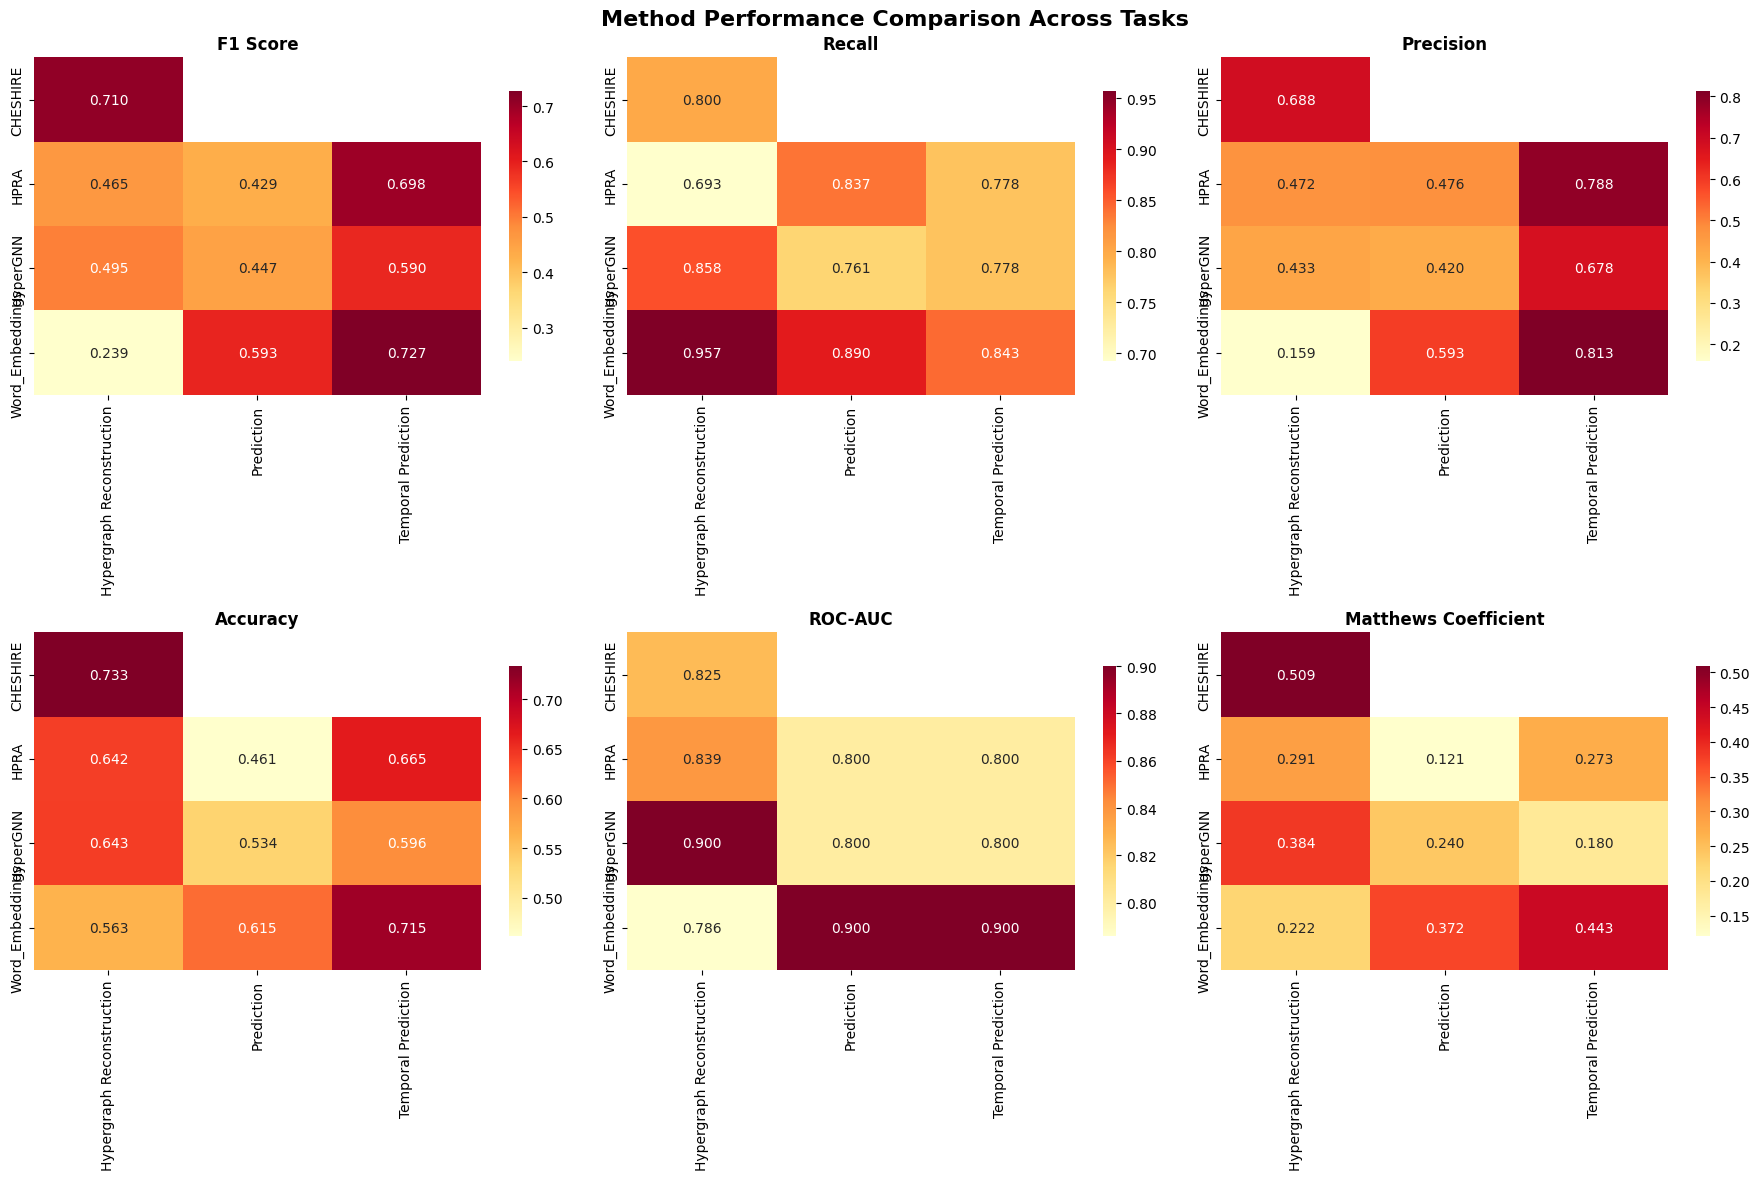

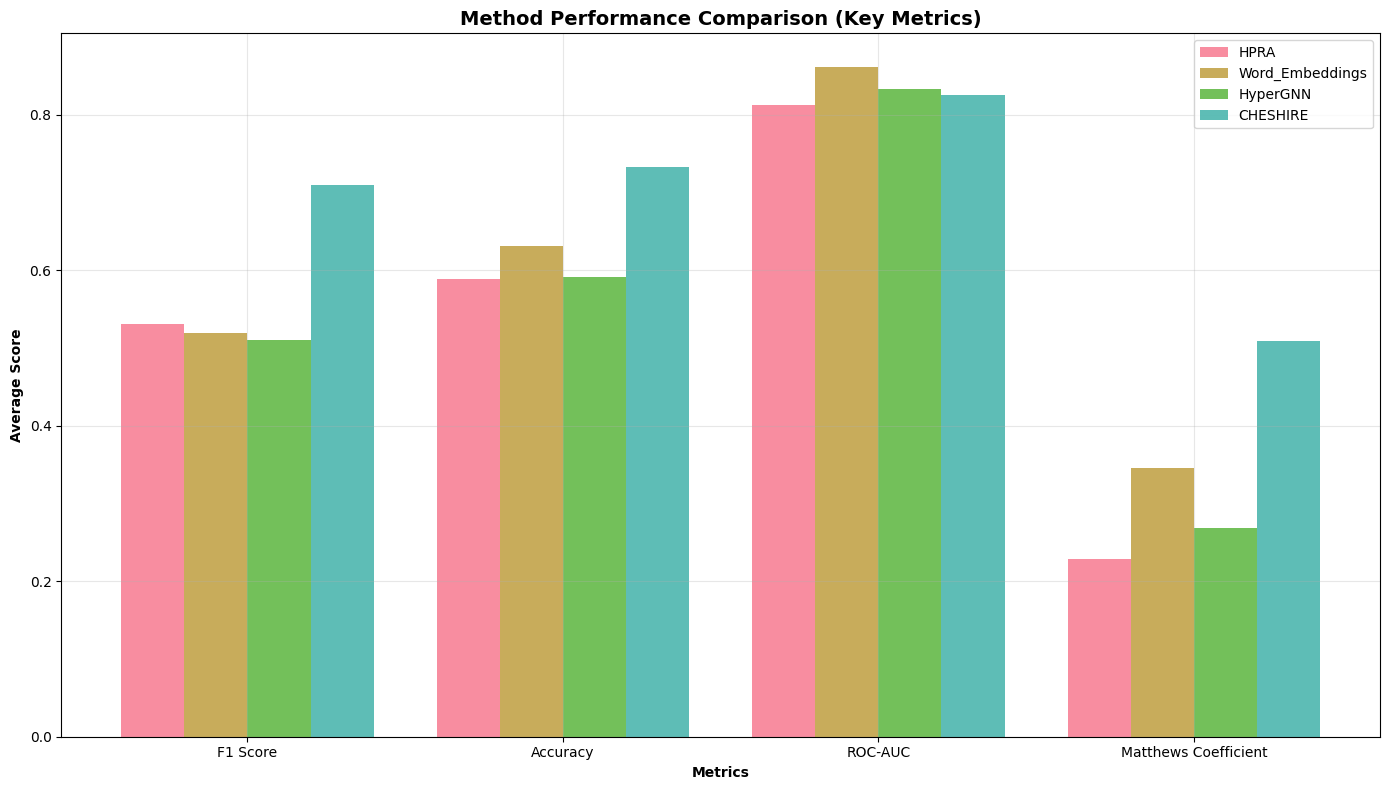

In [4]:
corrected_aggregator = run_corrected_extended_analysis("results")
corrected_aggregator.create_performance_visualizations()